In [1]:
from __future__ import print_function
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
import glob

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

Using TensorFlow backend.


In [2]:
steering.shape

NameError: name 'steering' is not defined

In [ ]:
steering.sort_values('timestamp').head()

In [ ]:
steering.angle.plot()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1)
steering.angle.plot(ax=ax[0])
steering.torque.plot(ax=ax[1])
steering.speed.plot(ax=ax[2])
plt.show()

In [ ]:
# {
#     'c': 3000,
#     'batch_size': 50,
#     'nb_epoch': 10,
#     'conv_2d': 1,
#     'dense': 2,
#     'dropout': 1,
#     'weight_init': 'uniform',
#     'split': 'alternate'
# }

In [3]:
c = 1000 # select first <c> frames to from dataset

# load images filenames
files_dir = "/Users/leisure/ai/datasets/udacity/output"
files_list = glob.glob(files_dir + '/center/*.jpg')
files_list = files_list[:c]

# load labels and select based on timestamps
steering=pd.read_csv(files_dir + '/steering.csv')
camera=pd.read_csv(files_dir + '/camera.csv')
ts_camera = camera[camera['frame_id']=='center_camera'].timestamp.values
i = 0
y_full = []
for j in range(len(steering)):
    if (steering.timestamp.values[j]>ts_camera[i]):
        y_full.append(steering.angle.values[j])
        if i==len(ts_camera)-1:
            break
        else:
            i+=1
y_full = y_full[:c]

# after selecting the steering angles closer to frames we are down to ~33000 samples
# the pattern is the same as figures above

In [4]:
# split training and test set in 5 frames intervals
y_full_tr = np.asarray([y_full[i:i+5] for i in range(0,c,10)]).flatten()
y_full_te = np.asarray([y_full[i:i+5] for i in range(5,c,10)]).flatten()

list_tr = [files_list[i:i+5] for i in range(0,c,10)]
files_list_tr = [item for sublist in list_tr for item in sublist]

list_te = [files_list[i:i+5] for i in range(5,c,10)]
files_list_te = [item for sublist in list_te for item in sublist]

# split training and test set half and half
y_full_tr2 = np.asarray(y_full[:len(y_full)]).flatten()
y_full_te2 = np.asarray(y_full[len(y_full)+1:]).flatten()

list_tr2 = files_list[:len(files_list)]
files_list_tr2 = [item for sublist in list_tr2 for item in sublist]

list_te2 = files_list[len(files_list)+1:]
files_list_te2 = [item for sublist in list_te2 for item in sublist]

In [5]:
def trainig_generator(y, files, batch_size, val_flag=0):
  """
  Define train generator.
  :param y_full: full vector of y labels/ observations
  :param files_list: full list of filenames for images
  """
  while 1:
    for i in range(0, len(y), batch_size):
      Y_train = y[i:i+batch_size]
      X_train = np.asarray([cv2.imread(j) for j in files[i:i+batch_size]])
      X_train = X_train.astype('float32')
      X_train /= 255
#       if not val_flag: 
#         print("\n")
#         print(str(i+1), 
#               Y_train[0],
#               len(Y_train))
      yield (X_train, Y_train)

In [12]:
# define simple model
batch_size = 50
nb_classes = 1
nb_epoch = 20
img_rows, img_cols = 480, 640
img_channels = 3

model = Sequential()

model.add(Convolution2D(24, 5, 5, border_mode='same',
                        input_shape=(img_rows, img_cols, img_channels),
                        subsample=(2,2), init='lecun_uniform'))
model.add(Activation('relu'))
model.add(Convolution2D(36, 5, 5, border_mode='same',
                        subsample=(2,2), init='lecun_uniform'))
model.add(Flatten())
model.add(Dense(100, init='lecun_uniform'))
model.add(Activation('relu'))
model.add(Dense(25, init='lecun_uniform'))
model.add(Activation('relu'))
# model.add(Dense(10, init='lecun_uniform'))
# model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
# model.add(Activation('softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='mean_squared_error', 
              optimizer=adam)

model.fit_generator(trainig_generator(y=y_full_tr, 
                                      files=files_list_tr,
                                      batch_size=batch_size),
                    samples_per_epoch=len(y_full_tr), 
                    nb_epoch=nb_epoch,
                    validation_data=trainig_generator(y=y_full_te, 
                                                      files=files_list_te, 
                                                      batch_size=batch_size,
                                                      val_flag=1),
                    nb_val_samples=len(y_full_tr))

Epoch 1/2
500/500 [==============================] - 97s - loss: 130.9105 - val_loss: 5.6067
Epoch 2/2
500/500 [==============================] - 100s - loss: 7.3401 - val_loss: 24.9099


In [9]:
def predict_generator(y, files, batch_size, val_flag=0):
  """
  Define train generator.
  :param y_full: full vector of y labels/ observations
  :param files_list: full list of filenames for images
  """
  while 1:
    for i in range(0, len(y), batch_size):
      Y_train = y[i:i+batch_size]
      X_train = np.asarray([cv2.imread(j) for j in files[i:i+batch_size]])
      X_train = X_train.astype('float32')
      X_train /= 255
#       print(i)
#       print(X_train.shape)
      yield X_train

In [16]:
# {
#     'c': 3000,
#     'batch_size': 50,
#     'nb_epoch': 10,
#     'conv_2d': 1,
#     'dense': 2,
#     'dropout': 0,
#     'weight_init': 'uniform',
#     'split': 'alternate'
# }
a = model.predict_generator(predict_generator(y=y_full, 
                                      files=files_list,
                                      batch_size=50) ,
                        val_samples=1000, 
                        max_q_size=100 
#                         nb_worker=1
                       )
plt.plot(y_full[:1100], c = 'b')
plt.plot(a[:1100], c='r')
plt.show()

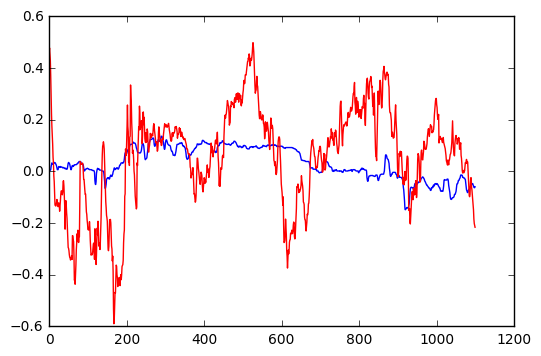

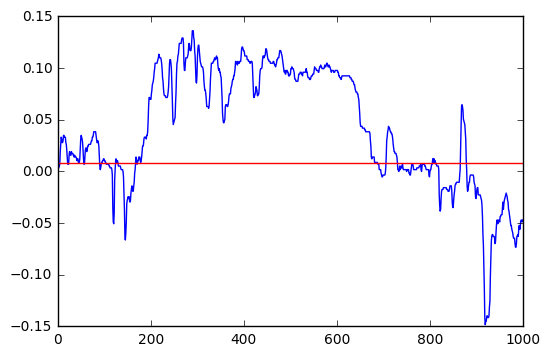

In [32]:
# {
#     'c': 1000,
#     'batch_size': 50,
#     'nb_epoch': 4,
#     'conv_2d': 3,
#     'dense': 2,
#     'dropout': 0,
#     'weight_init': 'uniform',
#     'split': 'alternate'
# }

b = model.predict_generator(predict_generator(y=y_full, 
                                      files=files_list,
                                      batch_size=50) ,
                        val_samples=1000, 
                        max_q_size=100
                       )
plt.plot(y_full, c = 'b')
plt.plot(b, c='r')
plt.show()

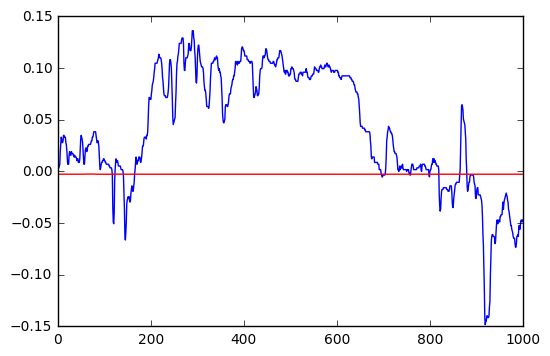

In [34]:
# {
#     'c': 1000,
#     'batch_size': 50,
#     'nb_epoch': 2,
#     'conv_2d': 2,
#     'dense': 2,
#     'dropout': 0,
#     'weight_init': 'uniform',
#     'split': 'alternate'
# }

c = model.predict_generator(predict_generator(y=y_full, 
                                      files=files_list,
                                      batch_size=50) ,
                        val_samples=1000, 
                        max_q_size=100
                       )
plt.plot(y_full, c = 'b')
plt.plot(c, c='r')
plt.show()

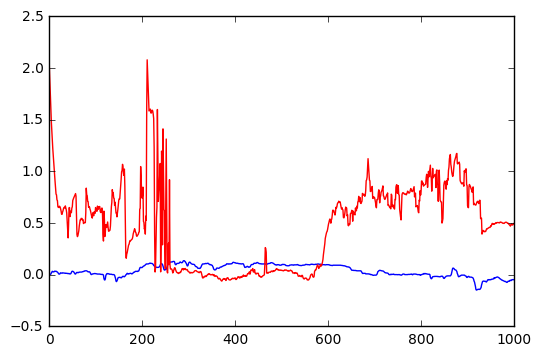

In [39]:
# {
#     'c': 1000,
#     'batch_size': 50,
#     'nb_epoch': 2,
#     'conv_2d': 1,
#     'dense': 2,
#     'dropout': 1,
#     'weight_init': 'lecun_uniform',
#     'split': 'alternate'
# }

d = model.predict_generator(predict_generator(y=y_full, 
                                      files=files_list,
                                      batch_size=50) ,
                        val_samples=1000, 
                        max_q_size=100
                       )
plt.plot(y_full, c = 'b')
plt.plot(d, c='r')
plt.show()

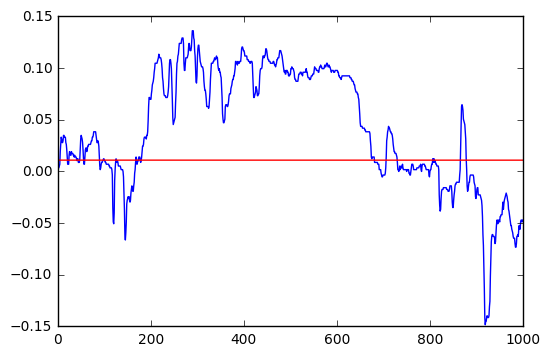

In [42]:
# {
#     'c': 1000,
#     'batch_size': 50,
#     'nb_epoch': 2,
#     'conv_2d': 2,
#     'dense': 2,
#     'dropout': 1,
#     'weight_init': 'lecun_uniform',
#     'split': 'alternate'
# }

e = model.predict_generator(predict_generator(y=y_full, 
                                      files=files_list,
                                      batch_size=50) ,
                        val_samples=1000, 
                        max_q_size=100 
                       )
plt.plot(y_full, c = 'b')
plt.plot(e, c='r')
plt.show()

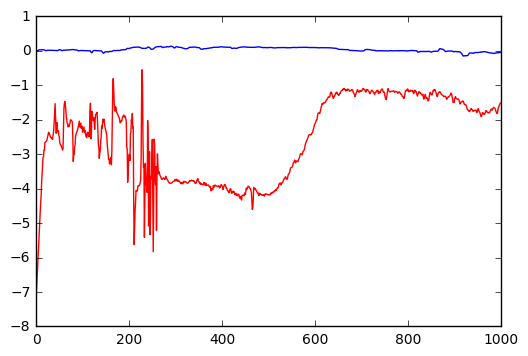

In [45]:
# {
#     'c': 1000,
#     'batch_size': 50,
#     'nb_epoch': 2,
#     'conv_2d': 1,
#     'dense': 3,
#     'dropout': 1,
#     'weight_init': 'lecun_uniform',
#     'split': 'alternate'
# }

f = model.predict_generator(predict_generator(y=y_full, 
                                      files=files_list,
                                      batch_size=50) ,
                        val_samples=1000, 
                        max_q_size=100 
                       )
plt.plot(y_full, c = 'b')
plt.plot(f, c='r')
plt.show()

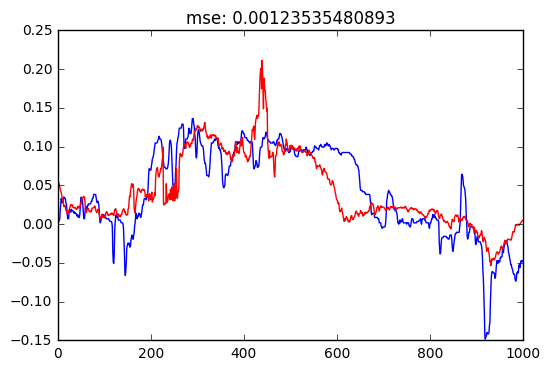

In [11]:
# {
#     'c': 1000,
#     'batch_size': 50,
#     'nb_epoch': 20,
#     'conv_2d': 2,
#     'dense': 2,
#     'dropout': 0,
#     'weight_init': 'lecun_uniform',
#     'split': 'alternate'
# }

from sklearn.metrics import mean_squared_error
mse = mean_squared_error

g = model.predict_generator(predict_generator(y=y_full, 
                                      files=files_list,
                                      batch_size=50) ,
                        val_samples=1000, 
                        max_q_size=100 
                       )
plt.plot(y_full, c = 'b')
plt.plot(g, c='r')
plt.title("mse: " + str(mse(y_full,g)))
plt.show()

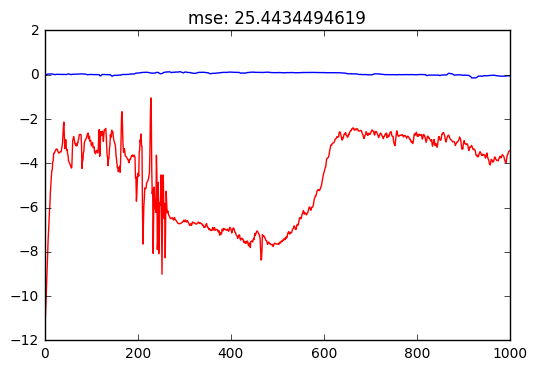

In [13]:
# {
#     'c': 1000,
#     'batch_size': 50,
#     'nb_epoch': 2,
#     'conv_2d': 2,
#     'dense': 2,
#     'dropout': 0,
#     'weight_init': 'lecun_uniform',
#     'split': 'alternate'
# }

h = model.predict_generator(predict_generator(y=y_full, 
                                      files=files_list,
                                      batch_size=50) ,
                        val_samples=1000, 
                        max_q_size=100 
                       )
plt.plot(y_full, c = 'b')
plt.plot(h, c='r')
plt.title("mse: " + str(mse(y_full,h)))
plt.show()

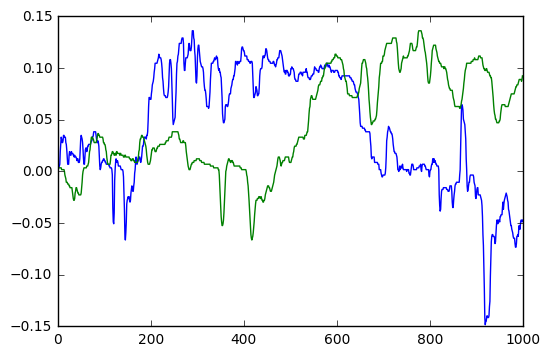

In [36]:
plt.plot(y_full, c = 'b')
plt.plot(steering.angle.values[:1000], c='g')
plt.show()

In [ ]:
params = 
{
    'sample':,
    
}